In [1]:
import os
import sys

from IPython.display import IFrame
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.patches as patches
import warnings
import networkx as nx
import osmnx as ox
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors

import urllib
import zipfile
import glob

# US COVID-19 Case Data Visualisation
## Procedure 1: US States and Counties GeoDataFrame (EPSG: 2163)

In [2]:
# Read US States Boundary Shapefile
us_states_gdf = gpd.read_file('Data/input/us_state/cb_2018_us_state_5m.shp')

# Converting the CRS to US National Atlas Equal Area Projection (EPSG: 2163)
us_states_gdf.to_crs(epsg=2163, inplace=True)

In [3]:
# Read US Counties Boundary Shapefile
us_counties_gdf = gpd.read_file('Data/input/us_counties/cb_2018_us_county_5m.shp')

# Adding a 'FULLFP' column that concatenates 'STATEFP' and 'COUNTYFP'
us_counties_gdf['FULLFP'] = us_counties_gdf['STATEFP'] + us_counties_gdf['COUNTYFP']

# Converting the CRS to US National Atlas Equal Area Projection (EPSG: 2163)
us_counties_gdf.to_crs(epsg=2163, inplace=True)

In [4]:
# Read US State Name, FIPS, and Postcode csv file 
fips_csv_dir = 'Data/input/us_state_fips/us-state-ansi-fips.csv'
fips_df = pd.read_csv(fips_csv_dir, dtype={' fips':object})

In [5]:
# Rename columns
fips_df.rename(columns=
    {' fips': 'fips',
    ' stusps': 'postcode',},
    inplace=True)

In [6]:
# Attribute Joins - Merging `us_counties_gdf` and `fips_df` on `'STATEFP'` and `'fips'`
merged_df = pd.merge(
    left=us_counties_gdf, 
    right=fips_df, 
    how='left', 
    left_on='STATEFP', 
    right_on='fips'
)

In [7]:
# Remove (drop) 'fips' column
merged_df = merged_df.drop(['fips'], axis=1)

In [8]:
# Make us_gdf a GeoDataFrame of merged_df
us_counties_gdf = gpd.GeoDataFrame(merged_df,
                                   crs={'init': 'epsg:2163'},
                                   geometry=merged_df['geometry'])

C:\Users\dun4g\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


## Procedure 2: US COVID-19 Cases/Deaths/Testing DataFrame
### [New York Times US Counties Data](https://github.com/nytimes/covid-19-data)

In [9]:
# Read NYTimes COVID-19 US Counties Data
nytimes_counties_df = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv', 
                                  dtype={'fips':object}
                                 )

In [10]:
# Changing the 'date' dtype from object to datetime
nytimes_counties_df['date']=pd.to_datetime(nytimes_counties_df['date'])

In [11]:
nytimes_counties_df.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061,1,0
1,2020-01-22,Snohomish,Washington,53061,1,0
2,2020-01-23,Snohomish,Washington,53061,1,0
3,2020-01-24,Cook,Illinois,17031,1,0
4,2020-01-24,Snohomish,Washington,53061,1,0


### <font color='red'> QUESTION: How come `nytimes_counties_plot_df.set_index` affects `nytimes_counties_df` as well? <font>

In [133]:
# nytimes_counties_plot_df = nytimes_counties_df
# nytimes_counties_plot_df.set_index('date', inplace=True)

### [COVID Tracking Project Latest US & States Current Data](https://covidtracking.com/api)

In [12]:
# Read COVID Tracking Project US COVID-19 Current Data
covtrack_us_now_df = pd.read_json('https://covidtracking.com/api/v1/us/current.json')

In [29]:
# Read COVID Tracking Project US States COVID-19 Current Data
covtrack_states_now_df = pd.read_json('https://covidtracking.com/api/v1/states/current.json', dtype={'fips':object})

### [COVID Tracking Project US Accumulative Data](https://covidtracking.com/api)

In [14]:
# Read COVID Tracking Project US COVID-19 Accumulative Data
covtrack_us_hist_df = pd.read_json('https://covidtracking.com/api/v1/us/daily.json', dtype={'fips':object})

In [15]:
# Creating a new column, 'datetime' that converts 'date' from dtype: int to the Dtype: str of datetime
covtrack_us_hist_df['datetime']=pd.to_datetime(covtrack_us_hist_df['date'].astype(str), format='%Y-%m-%d')

# Converting the Dtype to datetime
covtrack_us_hist_df['datetime']=pd.to_datetime(covtrack_us_hist_df['datetime'])

In [29]:
# # Creating a DataFrame for plotting charts (Set 'datetime' as the index)
# covtrack_us_hist_plot_df = covtrack_us_hist_df[['datetime', 'positive', 'death', 'total']]
# covtrack_us_hist_plot_df.set_index('datetime', inplace=True)

### [COVID Tracking Project States Accumulative Data](https://covidtracking.com/api)

In [16]:
# Read COVID Tracking Project US States COVID-19 Accumulative Data
covtrack_states_hist_df = pd.read_json('https://covidtracking.com/api/v1/states/daily.json', dtype={'fips':object})

In [17]:
# Creating a new column, 'datetime' that converts 'date' from dtype: int to the Dtype: str of datetime
covtrack_states_hist_df['datetime']=pd.to_datetime(covtrack_states_hist_df['date'].astype(str), format='%Y-%m-%d')

# Converting the Dtype to datetime
covtrack_states_hist_df['datetime']=pd.to_datetime(covtrack_states_hist_df['datetime'])

In [78]:
# # Creating a DataFrame for plotting charts (Set 'datetime' as the index)
# covtrack_states_hist_plot_df = covtrack_states_hist_df[['datetime', 'state', 'fips', 'positive', 'death', 'total']]
# covtrack_states_hist_plot_df.set_index('datetime', inplace=True)

## Procedure 3: Merge US COVID-19 DataFrame with GeoDataFrame `us_cov19_counties_gdf` and `us_cov19_states_gdf`
### `nytimes_counties_df`

In [32]:
# Merge NYTimes US Counties COVID-19 Data with us_counties_gdf
us_cov19_counties_df = pd.merge(
    nytimes_counties_df,
    us_counties_gdf[['FULLFP', 'STATEFP', 'COUNTYFP', 'geometry', 'postcode']],
    left_on='fips',
    right_on='FULLFP',
    how='left',
)

In [33]:
us_cov19_counties_gdf = gpd.GeoDataFrame(us_cov19_counties_df, 
                                         crs={'init': 'epsg:2163'},
                                         geometry='geometry')

C:\Users\dun4g\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [20]:
us_cov19_counties_gdf = us_cov19_counties_gdf.drop(['FULLFP'], axis=1)

In [21]:
us_cov19_counties_gdf.head()

,date,county,state,fips,cases,deaths,STATEFP,COUNTYFP,geometry,postcode
0,2020-01-21,Snohomish,Washington,53061,1,0,53,061,"MULTIPOLYGON (((-1634037.628 566970.701, -1633...",WA
1,2020-01-22,Snohomish,Washington,53061,1,0,53,061,"MULTIPOLYGON (((-1634037.628 566970.701, -1633...",WA
2,2020-01-23,Snohomish,Washington,53061,1,0,53,061,"MULTIPOLYGON (((-1634037.628 566970.701, -1633...",WA
3,2020-01-24,Cook,Illinois,17031,1,0,17,031,"POLYGON ((965008.651 -256879.590, 966661.997 -...",IL
4,2020-01-24,Snohomish,Washington,53061,1,0,53,061,"MULTIPOLYGON (((-1634037.628 566970.701, -1633...",WA


In [134]:
# us_cov19_counties_plot_gdf = us_cov19_counties_gdf['date', 'county', 'state', 'postcode', 'fips', 'STATEFP', 'COUNTYFP', 'cases', 'deaths', 'geometry']
# us_cov19_counties_plot_gdf.set_index('date', inplace=True)

### `covtrack_states_now_df`

In [34]:
# Merge COVID Tracking Project US States COVID-19 Accumulative Data with us_states_gdf
us_cov19_states_now_df = pd.merge(
    covtrack_states_now_df,
    us_states_gdf[['STATEFP', 'NAME', 'geometry']],
    left_on='fips',
    right_on='STATEFP',
    how='left',
)

In [35]:
us_cov19_states_now_gdf = gpd.GeoDataFrame(us_cov19_states_now_df, 
                                           crs={'init': 'epsg:2163'},
                                           geometry='geometry')

In [37]:
us_cov19_states_now_gdf = us_cov19_states_now_gdf.drop(['STATEFP'], axis=1)

### `covtrack_states_hist_df`

In [22]:
# Merge COVID Tracking Project US States COVID-19 Accumulative Data with us_states_gdf
us_cov19_states_df = pd.merge(
    covtrack_states_hist_df,
    us_states_gdf[['STATEFP', 'NAME', 'geometry']],
    left_on='fips',
    right_on='STATEFP',
    how='left',
)

In [23]:
us_cov19_states_gdf = gpd.GeoDataFrame(us_cov19_states_df, 
                                       crs={'init': 'epsg:2163'},
                                       geometry='geometry')

C:\Users\dun4g\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [24]:
us_cov19_states_gdf = us_cov19_states_gdf.drop(['STATEFP'], axis=1)

In [96]:
# # Creating a DataFrame for plotting charts (Set 'datetime' as the index)
# us_cov19_states_plot_gdf = us_cov19_states_gdf[['datetime', 'date', 'NAME', 'state', 'fips', 'positive', 'death', 'total', 'geometry']]
# us_cov19_states_plot_gdf.set_index('datetime', inplace=True)

In [26]:
us_cov19_states_gdf.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,datetime,NAME,geometry
0,20200504,AK,370.0,21353.0,NaN,12.0,NaN,NaN,NaN,NaN,...,21723.0,02,0.0,0.0,143.0,2.0,145.0,2020-05-04,Alaska,"MULTIPOLYGON (((-4288629.978 3426273.416, -428..."
1,20200504,AL,8025.0,95092.0,NaN,NaN,1064.0,NaN,411.0,NaN,...,103117.0,01,6.0,29.0,10317.0,300.0,10617.0,2020-05-04,Alabama,"MULTIPOLYGON (((1150023.442 -1526367.945, 1150..."
2,20200504,AR,3458.0,50984.0,NaN,91.0,438.0,NaN,NaN,16.0,...,54442.0,05,5.0,11.0,1525.0,27.0,1552.0,2020-05-04,Arkansas,"POLYGON ((482000.986 -928930.836, 487242.080 -..."
3,20200504,AS,0.0,83.0,NaN,NaN,NaN,NaN,NaN,NaN,...,83.0,60,0.0,0.0,26.0,0.0,26.0,2020-05-04,American Samoa,"MULTIPOLYGON (((-7800567.112 -3751033.523, -78..."
4,20200504,AZ,8919.0,76334.0,NaN,703.0,1357.0,288.0,NaN,200.0,...,85253.0,04,0.0,9.0,3855.0,279.0,4134.0,2020-05-04,Arizona,"POLYGON ((-1386135.563 -1256471.688, -1386636...."


## Procedure 4: US COVID-19 Data Visualisation
### US History Chart `covtrack_us_hist_df`

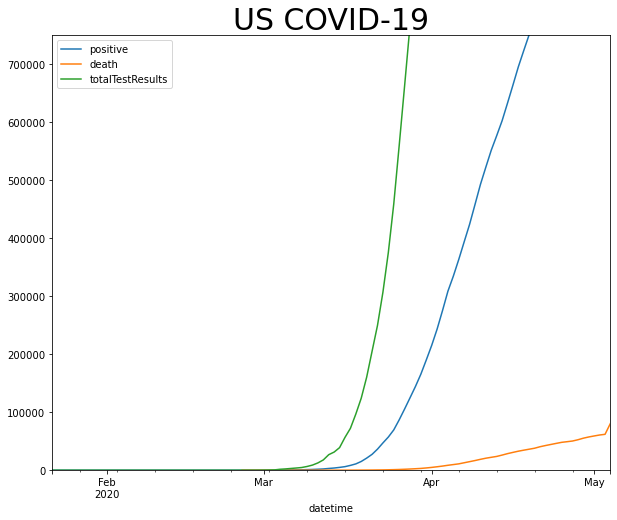

In [65]:
covtrack_us_hist_df.plot(
    x='datetime',
    y=['positive', 'death', 'totalTestResults'],
    xlim=()
    ylim=(0, 750000),
    figsize=(10, 8),
);

plt.title('Early US COVID-19', fontdict={'size':30});

### US States Confirmed Cases `us_cov19_states_now_gdf`
### <font color = 'red'> QUESTION: How do I put an automated today's date and time as a subtitle? </font>
### <font color = 'red'> QUESTION: How can I place Alaska more appropriate on the map? </font>

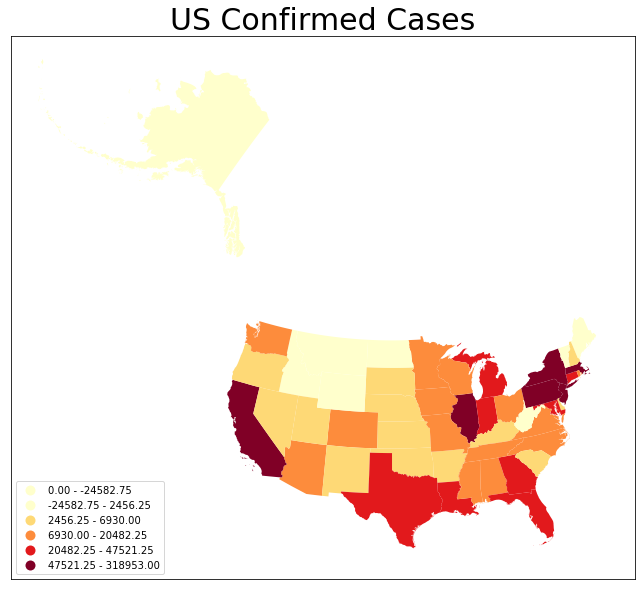

In [53]:
from datetime import date

fig, ax = plt.subplots(figsize=(15, 10))

us_cov19_states_now_gdf.plot(
    ax=ax,
    column='positive',
    legend=True,
    legend_kwds={'loc': 'lower left'},
    scheme='BoxPlot',
    cmap='YlOrRd',
)

# Title  
ax.set_title('US Confirmed Cases', fontdict={'size':30});

# Turn off the axes label
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# Crop the map to an appropriate size (via coordinate)
ax.set_xlim(-4700000, 3000000)
ax.set_ylim(-2500000, 4200000);

### by US Counties `us_cov19_counties_gdf`

In [ ]:
import plotly.express as px

us_cov19_counties_gdf.plot(
    column=''
)

### by US States `us_cov19_states_gdf`

# South Korea COVID-19 Case Data Visualisation
## Procedure 1: South Korea Provinces and Special/Metropolitan Cities GeoDataFrame (EPSG: 4326)

In [23]:
# Read in Natural Earth Large Scale Cultural Data (Admin 1 - States and Provinces) Boundary Shapefile
ne_admin_1_states_gdf = gpd.read_file('Data/input/ne_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp')

In [24]:
# Create a GeoDataFrame for South Korea Provinces & Special/Metropolitan Cities ONLY
south_korea_gdf=ne_admin_1_states_gdf[ne_admin_1_states_gdf['admin']=='South Korea']

In [25]:
# Keep the only columns that needed
south_korea_gdf = south_korea_gdf[['geonunit', 'gu_a3', 'gn_name', 'name_de', 'fips', 'latitude', 'longitude', 'geometry']]

## Procedure 2: South Korea COVID-19 Cases/Deaths/Testing DataFrame
### [South Korea Accumulative Data](https://github.com/katkim0307/COVID-19_Response_Comparison/blob/master/Data/input/covid_19_south_korea_full_xls.xlsx)

In [26]:
# Read 
kor_cov19_df = pd.read_excel('Data/input/covid_19_south_korea_full_xls.xlsx',
                            sheet_name='covid_19_daily_country')

kor_cov19_df.fillna(0, inplace=True)

In [31]:
# Creating a DataFrame for plotting charts (Set 'Date' as the index)
kor_cov19_plot_df = kor_cov19_df[['Date', 'Confirm_New', 'Confirm_Tot', 
                                'Death_New', 'Death_Tot', 
                                'Test_New', 'Test_Tot', 'Test_Curr']]
kor_cov19_plot_df.set_index('Date', inplace=True)

### [South Korea Provinces and Special/Metropolitan Cities Data](https://github.com/katkim0307/COVID-19_Response_Comparison/blob/master/Data/input/covid_19_south_korea_full_xls.xlsx)

In [27]:
# Read
kor_cov19_province_df = pd.read_excel('Data/input/covid_19_south_korea_full_xls.xlsx',
                                  sheet_name='covid_19_daily_province')


In [32]:
# Creating a DataFrame for plotting charts (Set 'Date' as the index)
kor_cov19_province_plot_df = kor_cov19_province_df[['Date', 'Province', 'Confirm_New', 'Confirm_Tot', 
                                                 'Death_New', 'Death_Tot', 
                                                 'Test_New', 'Test_Tot', 'Test_Curr']]
kor_cov19_province_plot_df.set_index('Date', inplace=True)

## Procedure 3: Merge South Korea COVID-19 DataFrame with GeoDataFrame 